In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from transformers import pipeline
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
from langchain_chroma import Chroma
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader, TextLoader

load_dotenv()

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
app_df = pd.read_csv('dataset/googleplaystore.csv')
print("Sample app data set")
app_df.head()

Sample app data set


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.10,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.90,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.70,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.50,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.30,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
review_df = pd.read_csv('dataset/googleplaystore_user_reviews.csv')
print("Sample review data set")
review_df.head()

Sample review data set


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.53
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.29
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.88
4,10 Best Foods for You,Best idea us,Positive,1.00,0.30


## Part 1: Data Preprocessing and Visualisation
### A. Removing the columns which are not required for the analysis

In [4]:
print('Size of the dataset before preprocessing: ', app_df.shape[0])
app_df = app_df[app_df['Size'].str.endswith('M')]
app_df = app_df[app_df['Size'] != 'Varies with device']
app_df['Size'] = app_df['Size'].str.replace('M', '').astype(float)
app_df['Installs'] = app_df['Installs'].str.replace(',', '').str.replace('+', '').astype(int)
app_df['Price'] = app_df['Price'].str.replace('$', '').astype(float)
app_df = app_df.drop(columns=['Android Ver', 'Current Ver', 'Last Updated'])
print('Size of the dataset after preprocessing: ', app_df.shape[0])

print('Size of the reviews dataset before preprocessing: ', review_df.shape[0])
review_df = review_df.drop_duplicates()
review_df = review_df.dropna()
review_df['SENTIMENT'] = review_df['Sentiment'].str.strip().str.upper()
print('Size of the reviews dataset after preprocessing: ', review_df.shape[0])
review_df = review_df.reset_index(drop=True)


Size of the dataset before preprocessing:  10841
Size of the dataset after preprocessing:  8829
Size of the reviews dataset before preprocessing:  64295
Size of the reviews dataset after preprocessing:  29692


### B. Some Application Data Visualization

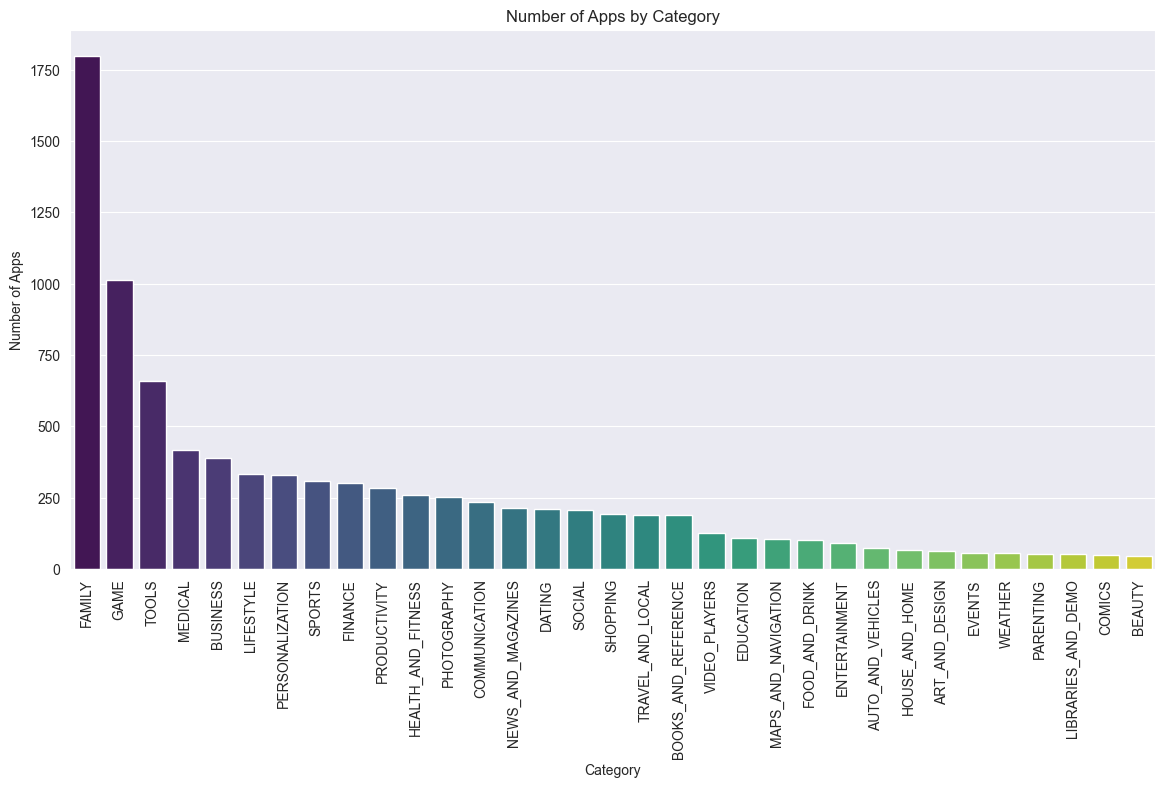


 Category wise information
╒════╤═════════════════════╤══════════════════╤═══════════════════╕
│    │ Category            │   Average_Rating │ Median_Installs   │
╞════╪═════════════════════╪══════════════════╪═══════════════════╡
│  0 │ EVENTS              │          4.46757 │ 1,000             │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  1 │ EDUCATION           │          4.39167 │ 1,000,000         │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  2 │ ART_AND_DESIGN      │          4.36102 │ 100,000           │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  3 │ PARENTING           │          4.34773 │ 100,000           │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  4 │ PERSONALIZATION     │          4.33672 │ 10,000            │
├────┼─────────────────────┼──────────────────┼───────────────────┤
│  5 │ LIBRARIES_AND_DEMO  │          4.32941 │ 100,000           │
├────┼──────────────

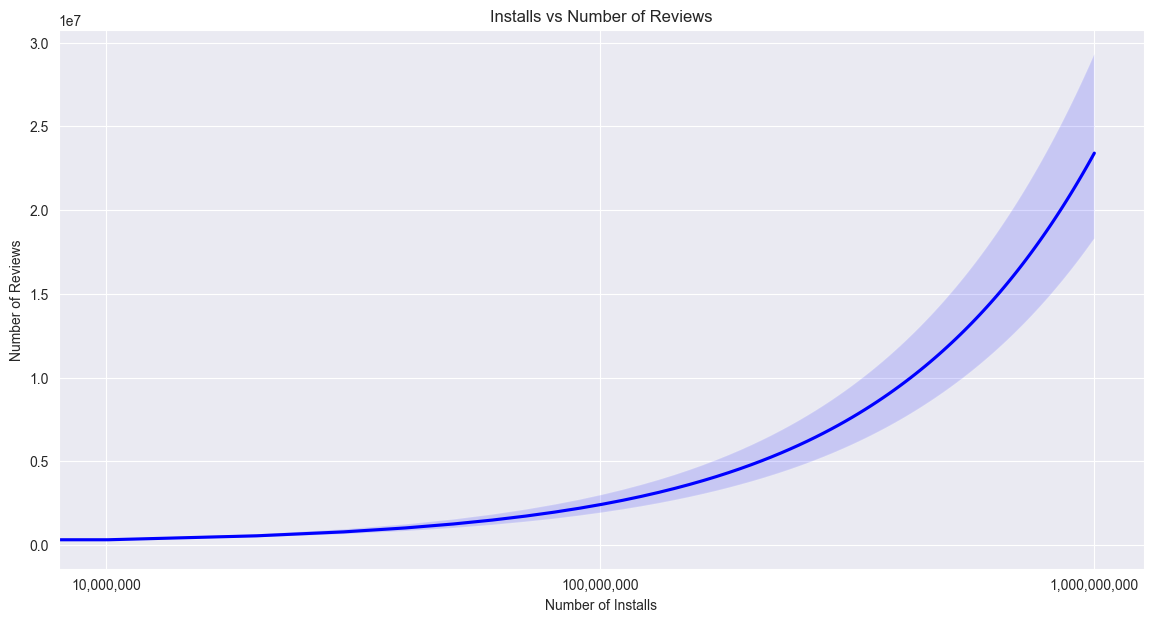


 Category wise information
╒════╤════════════╤═════════╤══════════════════╕
│    │ App Type   │   Count │   Average Rating │
╞════╪════════════╪═════════╪══════════════════╡
│  0 │ Free       │    8175 │          4.17282 │
├────┼────────────┼─────────┼──────────────────┤
│  1 │ Paid       │     654 │          4.27102 │
╘════╧════════════╧═════════╧══════════════════╛


In [5]:
from matplotlib.ticker import LogLocator, FuncFormatter

category_counts = app_df['Category'].value_counts()

plt.figure(figsize=(14, 7))
sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.index, palette='viridis')
plt.title('Number of Apps by Category')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.xticks(rotation=90)
plt.show()

category_stats = app_df.groupby('Category').agg(
    Average_Rating=('Rating', 'mean'),
    Median_Installs=('Installs', 'median')
).sort_values(by='Average_Rating', ascending=False)

category_stats = category_stats.reset_index()
category_stats['Median_Installs'] = category_stats['Median_Installs'].apply(lambda x: '{:,}'.format(int(x)))
print(category_stats.style.format(precision=3, thousands=".", decimal=",").format_index(str.upper, axis=1))

print("\n Category wise information")
print(tabulate(category_stats, headers='keys', tablefmt='fancy_grid'))

app_df['Installs'] = pd.to_numeric(app_df['Installs'], errors='coerce')
app_df['Reviews'] = pd.to_numeric(app_df['Reviews'], errors='coerce')
app_df = app_df.dropna(subset=['Installs', 'Reviews'])
plt.figure(figsize=(14, 7))
sns.regplot(data=app_df, x='Installs', y='Reviews', scatter=False, color='blue')
plt.title('Installs vs Number of Reviews')
plt.xlabel('Number of Installs')
plt.ylabel('Number of Reviews')
plt.xscale('log')
ax = plt.gca()
ax.xaxis.set_major_locator(LogLocator(base=10.0))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.show()

app_df['Rating'] = pd.to_numeric(app_df['Rating'], errors='coerce')
app_df['App Type'] = app_df['Price'].apply(lambda x: 'Free' if x == 0 or x == 0.0 else 'Paid')

app_type_counts = app_df['App Type'].value_counts()
average_ratings = app_df.groupby('App Type')['Rating'].mean()

summary_table = pd.DataFrame({
    'App Type': app_type_counts.index,
    'Count': app_type_counts.values,
    'Average Rating': average_ratings.values
})

print("\n Category wise information")
print(tabulate(summary_table, headers='keys', tablefmt='fancy_grid'))


In [6]:
most_downloaded_apps_by_category = app_df.loc[app_df.groupby('Category')['Installs'].idxmax()]
print("Most downloaded apps by category")
most_downloaded_apps_by_category

Most downloaded apps by category


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,App Type
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.50,215644,25.00,50000000,Free,0.00,Teen,Art & Design,Free
72,"Android Auto - Maps, Media, Messaging & Voice",AUTO_AND_VEHICLES,4.20,271920,16.00,10000000,Free,0.00,Teen,Auto & Vehicles,Free
7021,Best Hairstyles step by step,BEAUTY,4.50,45452,9.20,5000000,Free,0.00,Everyone,Beauty,Free
155,Oxford Dictionary of English : Free,BOOKS_AND_REFERENCE,4.10,363934,7.10,10000000,Free,0.00,Everyone,Books & Reference,Free
194,OfficeSuite : Free Office + PDF Editor,BUSINESS,4.30,1002861,35.00,100000000,Free,0.00,Everyone,Business,Free
311,comico Popular Original Cartoon Updated Everyd...,COMICS,3.20,93965,15.00,5000000,Free,0.00,Teen,Comics,Free
347,imo free video calls and chat,COMMUNICATION,4.30,4785892,11.00,500000000,Free,0.00,Everyone,Communication,Free
483,OkCupid Dating,DATING,4.10,285726,15.00,10000000,Free,0.00,Mature 17+,Dating,Free
700,TED,EDUCATION,4.60,181893,18.00,10000000,Free,0.00,Everyone 10+,Education,Free
874,Talking Angela,ENTERTAINMENT,3.70,1828284,52.00,100000000,Free,0.00,Everyone,Entertainment,Free


In [7]:
apps_with_high_number_of_reviews = app_df[app_df['Reviews'] >= 10000]
highest_rated_apps_by_category = apps_with_high_number_of_reviews.loc[apps_with_high_number_of_reviews.groupby('Category')['Rating'].idxmax()]
print("Highest rated apps by category (Min. 10k ratings)")
highest_rated_apps_by_category


Highest rated apps by category (Min. 10k ratings)


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,App Type
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.70,87510,8.70,5000000,Free,0.00,Everyone,Art & Design,Free
55,Tickets SDA 2018 and Exam from the State Traff...,AUTO_AND_VEHICLES,4.90,10479,33.00,100000,Free,0.00,Everyone,Auto & Vehicles,Free
99,"ipsy: Makeup, Beauty, and Tips",BEAUTY,4.90,49790,14.00,1000000,Free,0.00,Everyone,Beauty,Free
151,Free Books - Spirit Fanfiction and Stories,BOOKS_AND_REFERENCE,4.80,116507,5.00,1000000,Free,0.00,Teen,Books & Reference,Free
196,Job Search by ZipRecruiter,BUSINESS,4.80,148945,25.00,1000000,Free,0.00,Everyone,Business,Free
6407,WebComics,COMICS,4.80,33783,6.40,1000000,Free,0.00,Teen,Comics,Free
438,Should I Answer?,COMMUNICATION,4.80,237468,8.80,1000000,Free,0.00,Everyone,Communication,Free
515,Dating for 50 plus Mature Singles – FINALLY,DATING,4.60,13046,13.00,500000,Free,0.00,Mature 17+,Dating,Free
712,"Learn Japanese, Korean, Chinese Offline & Free",EDUCATION,4.90,133136,26.00,1000000,Free,0.00,Everyone,Education;Education,Free
882,🔥 Football Wallpapers 4K | Full HD Backgrounds 😍,ENTERTAINMENT,4.70,11661,4.00,1000000,Free,0.00,Everyone,Entertainment,Free


## Part 2: Sentiment Analysis


### A. Analyze distribution of sentiments

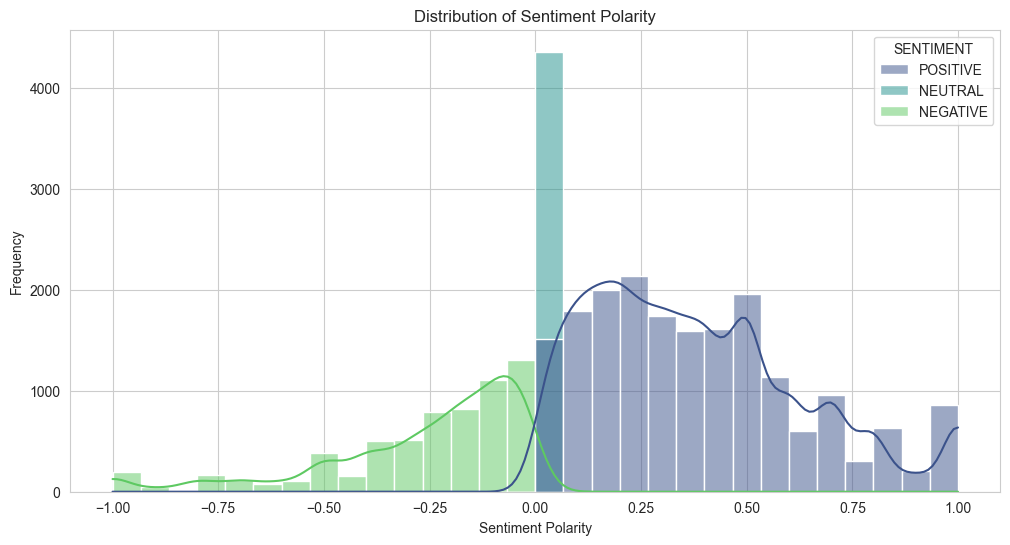

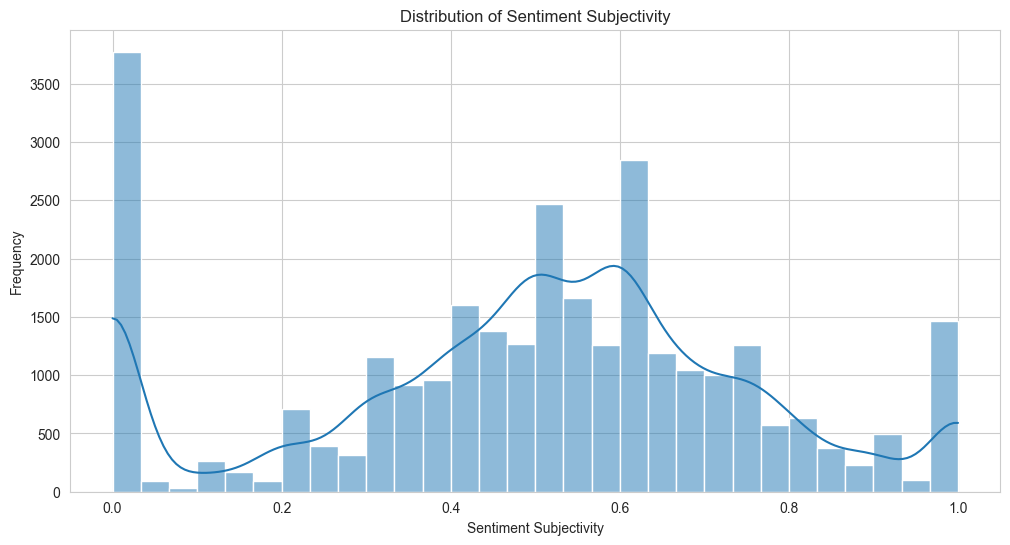

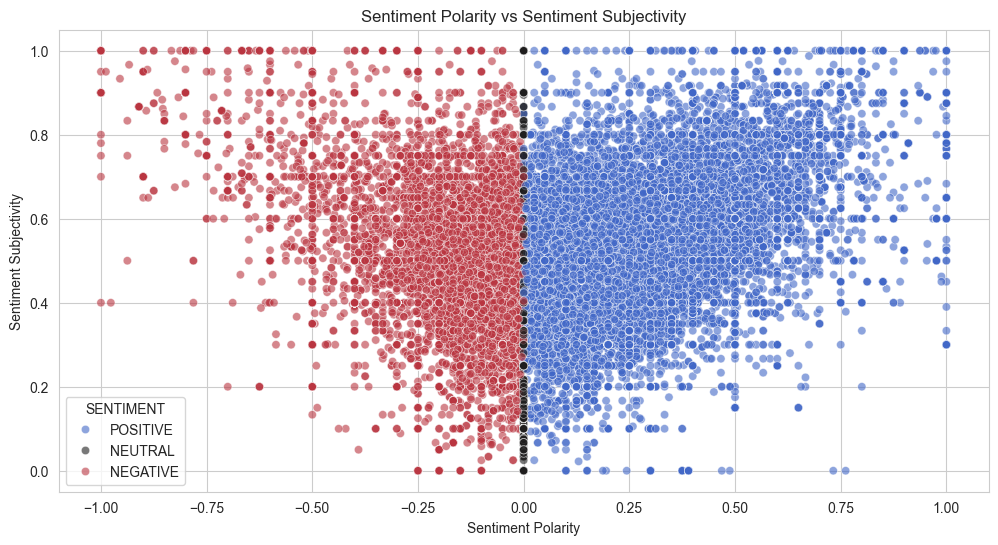

In [28]:
review_df['Sentiment_Polarity'] = pd.to_numeric(review_df['Sentiment_Polarity'], errors='coerce')
review_df['Sentiment_Subjectivity'] = pd.to_numeric(review_df['Sentiment_Subjectivity'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.histplot(review_df, x='Sentiment_Polarity', kde=True, bins=30, hue='SENTIMENT', palette='viridis')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(review_df, x='Sentiment_Subjectivity', kde=True, bins=30)
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Sentiment Subjectivity')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=review_df, x='Sentiment_Polarity', y='Sentiment_Subjectivity', hue='SENTIMENT', alpha=0.6, palette='icefire')
plt.title('Sentiment Polarity vs Sentiment Subjectivity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.show()

 ### B. Compare sentiments of a random reviews by BERT vs LLM

In [9]:
review_df = review_df.reset_index()
random_sample = review_df[['index', 'Translated_Review', 'SENTIMENT']].dropna().sample(n=50, random_state=42)
random_reviews = random_sample['Translated_Review'].astype(str).tolist()
label_mapping = {
    'LABEL_0': 'NEGATIVE',
    'LABEL_1': 'NEUTRAL',
    'LABEL_2': 'POSITIVE'
}
sentiment_analyzer = pipeline('sentiment-analysis', framework='tf', model='cardiffnlp/twitter-roberta-base-sentiment')
sentiment_results = sentiment_analyzer(random_reviews)
random_sample['ROBERTA_SENTIMENT'] = [label_mapping[result['label']] for result in sentiment_results]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


In [10]:
model = ChatOpenAI(model_name="gpt-4-turbo-2024-04-09")

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Determine the sentiment of each review and respond only with one word for each: POSITIVE, NEGATIVE, or NEUTRAL."),
        ("human", "\n".join([f"{idx + 1}. {review}" for idx, review in enumerate(random_sample['Translated_Review'])])),
    ]
)

batch_prompt = prompt_template.invoke({})
response = model.invoke(batch_prompt)
responses = response.content.strip().split('\n')
random_sample['LLM_SENTIMENT'] = [resp.split('. ')[-1] for resp in responses]
print('Random Sample of Sentiment Analysis Predictions')
random_sample.sample()

Random Sample of Sentiment Analysis Predictions


,index,Translated_Review,SENTIMENT,ROBERTA_SENTIMENT,LLM_SENTIMENT
5218,5218,Customer HORRIBLE,NEGATIVE,NEGATIVE,NEGATIVE


In [11]:
random_sample['ROBERTA_SENTIMENT'] = random_sample['ROBERTA_SENTIMENT'].str.strip().str.upper()
random_sample['LLM_SENTIMENT'] = random_sample['LLM_SENTIMENT'].str.strip().str.upper()
random_sample['Agreement'] = random_sample['ROBERTA_SENTIMENT'] == random_sample['LLM_SENTIMENT']

print('Agreement between ROBERTA and LLM:', random_sample['Agreement'].mean())
print('Number of disagreements:', (~random_sample['Agreement']).sum())
random_sample[random_sample['Agreement'] == False]


Agreement between ROBERTA and LLM: 0.8
Number of disagreements: 10


,index,Translated_Review,SENTIMENT,ROBERTA_SENTIMENT,LLM_SENTIMENT,Agreement
18356,18356,I open it in white. Uninstalled and installed ...,NEUTRAL,NEUTRAL,NEGATIVE,False
21468,21468,Have played game forever seems. The longer pla...,POSITIVE,POSITIVE,NEGATIVE,False
27339,27339,Play button sometimes dont apply When I tried ...,POSITIVE,NEUTRAL,NEGATIVE,False
26498,26498,"This trash I'm from, 7 restaurants available 5...",POSITIVE,NEUTRAL,NEGATIVE,False
18486,18486,It's good except passes get,POSITIVE,POSITIVE,NEUTRAL,False
12166,12166,This ok... least chat free much better apps! I...,POSITIVE,NEUTRAL,NEGATIVE,False
25487,25487,"After last update, I thought functions gone. I...",POSITIVE,POSITIVE,NEUTRAL,False
12621,12621,This game fun something matchmaking. You fight...,NEGATIVE,NEUTRAL,NEGATIVE,False
28310,28310,"I love game, many ads. I even get ads phone us...",NEGATIVE,POSITIVE,NEGATIVE,False
21724,21724,Not bad...,POSITIVE,POSITIVE,NEUTRAL,False


### Comments of Disagreement Between ROBERTA and LLM Sentiment

The disagreement between the **ROBERTA Sentiment** and the **LLM Sentiment** classifications in the dataset could be because of the following reasons:

#### 1. **Word-wise interpretations**
- ROBERTA see,s to focus on individual words and phrases to determine sentiment, which may lead to a more literal interpretation.
- LLM: Has a deeper understanding of context and can infer sentiment based on the overall meaning of the text.

##### Eg:
- **Sentence**: "I love game, many ads. I even get ads phone use. Its annoying, fun game."
  - ROBERTA: `POSITIVE`
  - LLM: `NEUTRAL`

---

#### 2. **Handling of inverted Sentiments**
- ROBERTA may overemphasis one aspect in a sentence (especially for inverted sentiments).
- LLMs tend to balance conflicting sentiments.

##### Example:
- **Sentence**: "Not bad..."
  - ROBERTA: `POSITIVE`
  - LLM: `NEUTRAL`

---

#### 3. **Sentence Structure/Grammar and Context**
- ROBERTA is struggling with Grammar.
- LLMs are generally better at understanding such texts due to their ability to infer context.

##### Example:
- **Sentence**: "Have played game forever seems. The longer play, harder gets win. Loved everything til started changing fish. I love natural real life fish. Don't like new fish enjoy playing more. On 603 level thinking quitting. Doesn't calm more. Still go first aquariums play I enjoyed them. Please knock new type fish. Make new game leave mine alone please Thanks."
  - ROBERTA: `POSITIVE`
  - LLM: `NEUTRAL`

---

### Conclusion
**IN MY FINDINGS**, LLMs beat Sentiment Analysis models in every aspect. Part of the reason could be because of the varying data that both these models are trained on. `cardiffnlp/twitter-roberta-base-sentiment` is trained on Twitter data, and other BERT models are also similarly trained on Tweets, Books, and/or Wikipedia pages. However, the data scraped by OpenAI is, well, **HUGE!** Hence, the difference and better performance. Also, most of the difference are one step differences (`POSITIVE` vs `NEUTRAL` **OR** `NEUTRAL` vs `POSTIVE`). So they do not disagree entirely (in most disagreement cases).

## Part 3: Insights and guidance

### A. Combine data of both the datasets and get insights from LLM model

In [12]:
review_grouped = review_df.groupby('App').agg({
    'Translated_Review': list
}).reset_index()
review_grouped['Translated_Reviews'] = review_grouped['Translated_Review'].apply(
    lambda reviews: ', '.join([f"'{review}'" for review in reviews])
)
merged_df = pd.merge(app_df, review_grouped, on='App', how='inner')
print("Number of application with reviews: ", merged_df.shape[0])

Number of application with reviews:  806


In [13]:
merged_df['Context'] = merged_df.apply(
    lambda row: f"App Name: {row['App']}\n"
                f"Category: {row['Category']}\n"
                f"Rating: {row['Rating']}\n"
                f"Reviews: {', '.join(row['Translated_Review'][:5])}",
    axis=1
)
grouped = merged_df.groupby('Category')
output_dir = 'category_files'
os.makedirs(output_dir, exist_ok=True)
for category, group in grouped:
    file_path = os.path.join(output_dir, f"{category}.txt")
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(f"Category: {category}\n\n")
        for _, row in group.iterrows():
            reviews = '; '.join(row['Translated_Review'][:5])
            file.write(f"App Name: {row['App']}\n")
            file.write(f"Rating: {row['Rating']}\n")
            file.write(f"Reviews: {reviews}\n\n")

In [14]:
loader = DirectoryLoader('./category_files/', glob="./*.txt", loader_cls=TextLoader)
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=0)
documents = text_splitter.split_documents(documents)

#TODO: The embeddings are being saved in the ChromaDB. Need to load embeddings from there rather than calling OpenAIEmbeddings again ($$$$)
vector_store = Chroma.from_documents(
    collection_name="google_play_store",
    documents=documents,
    embedding=OpenAIEmbeddings(),
    persist_directory="azure_embeddings"
)

In [23]:
retriever = vector_store.as_retriever(search_kwargs={"k": 33})
llm = ChatOpenAI()
query = "What are general user opinions on Clash Royale? What are other games app with more than 4.5 rating?"
system_prompt = (
    "Use the given context to answer the question. "
    "If you don't know the answer, say you don't know. "
    "Use two sentences maximum and keep the answer concise. "
    "The reviews of apps are semi-colon separated. "
    "Provide summary of reviews in one line. "
    "Provide answers in bullet points."
    "Do not give answers that are not in the context."
    "Context: {context}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, prompt)
chain = create_retrieval_chain(retriever, question_answer_chain)

print("TIME FOR GAMES APP ANALYSIS! Query: ", query)
response = chain.invoke({"input": query})
print(response['answer'])

query = "What are best food Recipes app out there? Give me three apps mentioning the reviews."
print("\n \n \n \nTIME FOR FOOD ANALYSIS! Query: ", query)
response = chain.invoke({"input": query})
print(response['answer'])

query = "What apps are 4.5+ rated for health? Recommend apps for home workouts."
print("\n \n \n \nNOW TIME TO CARE ABOUT HEALTH! Query: ", query)
response = chain.invoke({"input": query})
print(response['answer'])

TIME FOR GAMES APP ANALYSIS! Query:  What are general user opinions on Clash Royale? What are other games app with more than 4.5 rating?
- General user opinions on Clash Royale are mixed with some users feeling that the game favors big spenders and has rigged deck rotations, while others enjoy it as a challenging and engaging game with good gameplay.
- Other game apps with more than a 4.5 rating include Among Us, Garena Free Fire, PUBG Mobile, and Roblox.

 
 
 
TIME FOR FOOD ANALYSIS! Query:  What are best food Recipes app out there? Give me three apps mentioning the reviews.
- **Cookpad**: Receives positive reviews mentioning tasty recipes, new recipes, and making cooking easier.
- **Eat Fit - Diet and Health Free**: Users express passion for nutrition and health, but some reviews mention issues with the app's configuration and weight tracking.
- **10 Best Foods for You**: Users appreciate the app for helping with healthy eating and regular exercise, especially when going to the groc

### B. Generate User Data

10 Users with 80 apps each. User data contains the information about App Name, Category and Rating


In [16]:
def generate_user_data(df, num_users, num_apps=80):
    user_data = []
    for user_id in range(1, num_users + 1):
        random_apps = df.sample(n=num_apps)
        user_info = {
            "User": f"User_{user_id}",
            "Apps": random_apps.to_dict(orient="records")
        }
        user_data.append(user_info)
    return user_data


filtered_df = merged_df[['App', 'Category', 'Genres', 'Rating']]
num_users = 10
user_data = generate_user_data(filtered_df, num_users)

print("Sample data for how user looks like: ")
for app in user_data[0]['Apps'][:5]:
    print(app)


Sample data for how user looks like: 
{'App': 'Dog Licks Screen Wallpaper', 'Category': 'PERSONALIZATION', 'Genres': 'Personalization', 'Rating': 4.3}
{'App': 'ARY NEWS', 'Category': 'NEWS_AND_MAGAZINES', 'Genres': 'News & Magazines', 'Rating': 4.4}
{'App': 'DC Super Hero Girls™', 'Category': 'FAMILY', 'Genres': 'Action;Action & Adventure', 'Rating': 4.3}
{'App': 'Cougar Dating Life : Date Older Women Sugar Mummy', 'Category': 'DATING', 'Genres': 'Dating', 'Rating': 3.9}
{'App': 'Football Live Scores', 'Category': 'SPORTS', 'Genres': 'Sports', 'Rating': 4.5}


### C. Recommendations for Users for replacing apps with low ratings

#### 1. Each user has 80 apps. Keep apps from each user's list which have rating less than 4.0 (assuming an app with 4.0+ rating is already a good one)

In [17]:
for user in user_data:
    user['Apps'] = [app for app in user['Apps'] if app['Rating'] < 4.0]

#### 2. Figure out based on what should the documents be created

##### a. How about we create documents based on category again, but now only with high rating apps?

In [18]:
high_rating_apps = merged_df[merged_df['Rating'] >= 4.0]
grouped_by_category = high_rating_apps.groupby('Category').size().reset_index(name='Number of Records')
print(tabulate(grouped_by_category, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════════════╤═════════════════════╕
│    │ Category            │   Number of Records │
╞════╪═════════════════════╪═════════════════════╡
│  0 │ ART_AND_DESIGN      │                   8 │
├────┼─────────────────────┼─────────────────────┤
│  1 │ AUTO_AND_VEHICLES   │                   6 │
├────┼─────────────────────┼─────────────────────┤
│  2 │ BEAUTY              │                   4 │
├────┼─────────────────────┼─────────────────────┤
│  3 │ BOOKS_AND_REFERENCE │                   9 │
├────┼─────────────────────┼─────────────────────┤
│  4 │ BUSINESS            │                  21 │
├────┼─────────────────────┼─────────────────────┤
│  5 │ COMICS              │                   1 │
├────┼─────────────────────┼─────────────────────┤
│  6 │ COMMUNICATION       │                  20 │
├────┼─────────────────────┼─────────────────────┤
│  7 │ DATING              │                  37 │
├────┼─────────────────────┼─────────────────────┤
│  8 │ EDUCATION           │   

##### b. How about we create documents based on ratings (all 4.5 rated apps in one file, 4.6 in another, 4.7 ....)?


In [19]:
grouped_by_rating = high_rating_apps.groupby('Rating').size().reset_index(name='Number of Records')
print(tabulate(grouped_by_rating, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════╤═════════════════════╕
│    │   Rating │   Number of Records │
╞════╪══════════╪═════════════════════╡
│  0 │      4   │                  51 │
├────┼──────────┼─────────────────────┤
│  1 │      4.1 │                  72 │
├────┼──────────┼─────────────────────┤
│  2 │      4.2 │                  86 │
├────┼──────────┼─────────────────────┤
│  3 │      4.3 │                 119 │
├────┼──────────┼─────────────────────┤
│  4 │      4.4 │                 130 │
├────┼──────────┼─────────────────────┤
│  5 │      4.5 │                 102 │
├────┼──────────┼─────────────────────┤
│  6 │      4.6 │                  90 │
├────┼──────────┼─────────────────────┤
│  7 │      4.7 │                  43 │
├────┼──────────┼─────────────────────┤
│  8 │      4.8 │                  13 │
├────┼──────────┼─────────────────────┤
│  9 │      4.9 │                   3 │
╘════╧══════════╧═════════════════════╛


##### **DECISION**: Let's go with the first approach. We will create documents based on cateogry.
Why? Because it is more likely that a user would want to replace an app with a higher rated app in the same category.
Also, if I had made the documents based on ratings, all the documents would be included in context. Plus all documents would have all kinds of categories. This would make the model confused, and it would not be able to provide accurate recommendations.

In [20]:
output_dir = 'high_rated_category_files'
os.makedirs(output_dir, exist_ok=True)
for category, group in high_rating_apps.groupby('Category'):
    file_path = os.path.join(output_dir, f"{category}.txt")
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(f"Category: {category}\n\n")
        for _, row in group.iterrows():
            reviews = '; '.join(row['Translated_Review'][:5])
            file.write(f"App Name: {row['App']}\n")
            file.write(f"Rating: {row['Rating']}\n")
            file.write(f"Reviews: {reviews}\n")
            file.write(f"Genres: {row['Genres']}\n\n")

In [21]:
high_rated_category_loader = DirectoryLoader('./high_rated_category_files/', glob="./*.txt", loader_cls=TextLoader)
high_rated_category_documents = high_rated_category_loader.load()
high_rated_category_text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=0)
high_rated_category_documents = high_rated_category_text_splitter.split_documents(high_rated_category_documents)

high_rated_category_vector_store = Chroma.from_documents(
    documents=high_rated_category_documents,
    embedding=OpenAIEmbeddings(),
)

In [22]:
retriever = high_rated_category_vector_store.as_retriever(search_kwargs={"k": 10})
high_rated_category_llm = ChatOpenAI(
    presence_penalty=0.4,
    frequency_penalty=0.8
)

high_rated_category_system_prompt = (
    '''
    You are Replacement App GPT, assigned to recommend replacement apps strictly based on the provided Context. Follow these rules exactly:

    1. Use only the information provided in the Context for recommendations.
    2. Input format: "App Name: <app_name>, Category: <category>, Genres: <genres> Rating: <rating>"
    3. Recommend a replacement app only if:
       * The recommended app from Context MUST HAVE the same Category as that of original app.
       * The recommended app from Context MUST HAVE the same Genres as that of original app.
       * The recommended app MUST HAVE a Rating of 4.4 or higher.
       * The recommended app MUST NOT listed in the human-input apps.
       * If multiple replacement apps are available, recommend the one with the highest rating.
    4. Output format: "Original App: <app_name>, Replacement App: <replacement_app_name>, Replacement App Rating: <replacement_app_rating>"
    5. Do not recommend a replacement app if there is no valid option.
    6. Provide recommendations strictly in the specified format without any additional explanations, comments, or deviations.
    Context: {context}
'''
)
high_rated_category_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", high_rated_category_system_prompt),
        ("human", "{input}"),
    ]
)
high_rated_category_question_answer_chain = create_stuff_documents_chain(high_rated_category_llm,
                                                                         high_rated_category_prompt)
high_rated_category_chain = create_retrieval_chain(retriever, high_rated_category_question_answer_chain)
query = ""
result_file_path = "recommendation_results.txt"

with open(result_file_path, "w") as result_file:
    for user in user_data:
        query = ""
        result_file.write(f"Recommendations for {user['User']}\n")
        for app in user['Apps']:
            sub_query = ", ".join([f"{key}: {value}" for key, value in app.items()])
            query += f"{sub_query}\n"
        response = high_rated_category_chain.invoke({"input": query})
        result_file.write(f"{response['answer']}\n\n")